- Reference: A Bind RGB Color Image Watermarking Based On Singular Value Decomposition


In [1]:
# google drive
# from google.colab import drive
# drive.mount('/content/drive')
# file address in google drive
file_root = './'

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def norm_img(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [4]:
def pltshow(img,gray=False):
    plt.figure(figsize=(5,5))
    plt.axis('off')
    if(gray):
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)

In [5]:
# load and show original image
img = cv2.imread('%sbeagle0.jpg'%file_root)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [6]:
# load and show watermark image
wm = cv2.imread('%savatar2.jpg'%file_root)
wm = cv2.cvtColor(wm,cv2.COLOR_BGR2RGB)
# wm = cv2.resize(wm,dsize=(800,800),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)

In [7]:
def resize_wm(wm,img):
    img_x,wm_x = img.shape[0],wm.shape[0]
    resize_x = wm_x
    img_y,wm_y = img.shape[1],wm.shape[1]
    resize_y = wm_y
    for x in range(wm.shape[0],0,-1):
        if img.shape[0] % x == 0:
            resize_x = x
            break
    for y in range(wm.shape[1],0,-1):
        if img.shape[1] % y == 0:
            resize_y = y
            break
    wm_resize = cv2.resize(wm,dsize=(resize_y,resize_x),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)
    return wm_resize

In [8]:
def embed_sv_block(img_block,wm_v,K=3,n=2):
    u,s,vt = np.linalg.svd(img_block)
    embed_v = wm_v/K
    s[n] = embed_v
    for x in range(n,0,-1):
        if s[x] >= embed_v:
            break
        else:
            s[x] = embed_v
    for x in range(n+1,len(s)):
        if s[x] <= embed_v:
            break
        else:
            s[x] = embed_v
    s = np.diag(s)
    s = np.pad(s,\
        ((0,img_block.shape[0]-s.shape[0]),
         (0,img_block.shape[1]-s.shape[1])),
         mode='constant')
    res = np.dot(np.dot(u,s),vt)
    return res

In [9]:
def embed_wm(img,wm,K=3,n=2):
    wm = resize_wm(wm,img)
    block_x = img.shape[0]//wm.shape[0]
    block_y = img.shape[1]//wm.shape[1]
    wmed_img = img.copy()
    for ch in range(3):
        img_ch = img[...,ch]
        for x in range(wm.shape[0]):
            for y in range(wm.shape[1]):
                img_block = img_ch[x*block_x:(x+1)*block_x,y*block_y:(y+1)*block_y]
                wmed_img[x*block_x:(x+1)*block_x,y*block_y:(y+1)*block_y,ch] = \
                embed_sv_block(img_block,wm[x,y,ch],K=K,n=n)
    return wmed_img

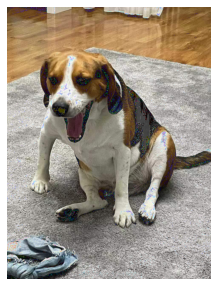

In [10]:
wmed_img = embed_wm(img,wm,K=5,n=2)
pltshow(wmed_img)

In [11]:
def extract_wm(img,wm_size=[320,320,3],K=5,n=2):
    wm = np.zeros(wm_size)
    block_x = img.shape[0]//wm_size[0]
    block_y = img.shape[1]//wm_size[1]
    for ch in range(3):
        img_ch = img[...,ch]
        for x in range(wm.shape[0]):
            for y in range(wm.shape[1]):
                img_block = img_ch[x*block_x:(x+1)*block_x,y*block_y:(y+1)*block_y]
                u,s,vt = np.linalg.svd(img_block)
                wm[x,y,ch] = int(s[n]*K)
    return wm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


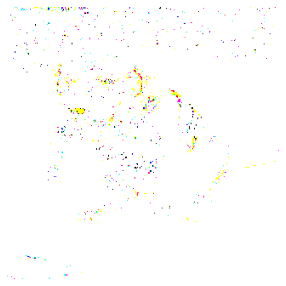

In [12]:
wm_extracted = extract_wm(wmed_img)
pltshow(wm_extracted)

In [13]:
ecnu = cv2.imread('%secnu.jpg'%file_root)
ecnu = cv2.cvtColor(ecnu,cv2.COLOR_BGR2RGB)

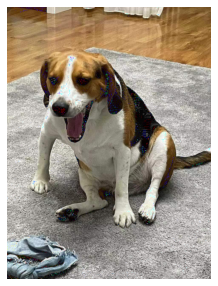

In [14]:
wmed_img_ecnu = embed_wm(img,ecnu,K=10,n=2)
pltshow(wmed_img_ecnu)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


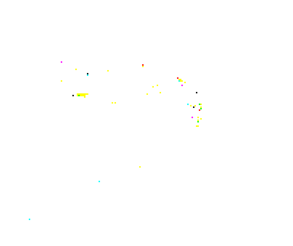

In [15]:
ecnu_extracted = extract_wm(wmed_img_ecnu,wm_size=[160,192,3],K=10,n=2)

pltshow(ecnu_extracted)

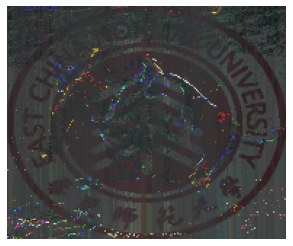

In [26]:
from sklearn import  preprocessing
e_scaled = np.stack((preprocessing.scale(ecnu_extracted[...,0]),
                    preprocessing.scale(ecnu_extracted[...,1]),
                    preprocessing.scale(ecnu_extracted[...,2])),
                    axis=2)
pltshow(norm_img(e_scaled))

In [27]:
def show_wm_extracted(wm):
    scaled = np.stack((preprocessing.scale(wm[...,0]),
                        preprocessing.scale(wm[...,1]),
                        preprocessing.scale(wm[...,2])),
                        axis=2)
    pltshow(norm_img(scaled))